This is an continuation of the 1st attempt at creating a reasonably good model for the Heart Disease dataset. I will try to address the following issue that I found in the 1st attempt:
1. The labels are unbalanced: the number of people who don't have heart diease is 10.7 times the number of people who do.
2. Some features are also unbalanced. For example, features like "AlcoholDrinking", "Stroke", "Race", "KidneyDiease" all have one value that has more count than all other values combined.
3. All the classifiers trained in the 1st attempt has very low precision & recall for the "yes" label. Most classifiers have a high overall accuracy because they predict most instances to be "no". This is not a good result for this project as we want to have a high recall (preferably also high precision) for the "yes" label).                                                             

In [2]:
import pandas as pd
import dill

In [3]:
data = pd.read_csv('heart_2020_cleaned.csv')

In [4]:
# one-hot encoding
category_cols = [col for col in data.columns if data[col].dtype == 'object']
data = pd.get_dummies(data=data, columns=category_cols, drop_first=True)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop(['HeartDisease_Yes'], axis=1), data['HeartDisease_Yes'], test_size=0.2, random_state=42)

<AxesSubplot:ylabel='HeartDisease_Yes'>

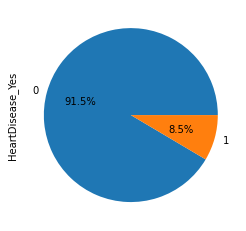

In [6]:
y_train.value_counts().plot(kind='pie', autopct='%1.1f%%')

In [7]:
from sklearn.preprocessing import StandardScaler

# this is the exact same as feature scaling in the 1st exploration
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

1. Random Undersampling

In [8]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
y_train_rus.value_counts()

0    21781
1    21781
Name: HeartDisease_Yes, dtype: int64

2. Random Oversampling

In [9]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
y_train_ros.value_counts()

0    234055
1    234055
Name: HeartDisease_Yes, dtype: int64

3. SMOTE

In [10]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
y_train_smote.value_counts()

0    234055
1    234055
Name: HeartDisease_Yes, dtype: int64

4. Tomek Links

In [11]:
from imblearn.under_sampling import TomekLinks

# TomekLinks runtime is O(n^2), so we will use a smaller dataset in this case

size = 25000
tl = TomekLinks()
X_train_tl, y_train_tl = tl.fit_resample(X_train[:size], y_train[:size])
y_train_tl.value_counts()

0    22109
1     2111
Name: HeartDisease_Yes, dtype: int64

5. Combining SMOTE and Tomek Links

In [12]:
from imblearn.combine import SMOTETomek

# again, we will use a smaller dataset

smote_tl = SMOTETomek(random_state=42)
X_train_smote_tl, y_train_smote_tl = smote_tl.fit_resample(X_train[:size], y_train[:size])
y_train_smote_tl.value_counts()

0    22662
1    22662
Name: HeartDisease_Yes, dtype: int64

Now let's train some classifiers on the balanced data.
<br>
**NOTE**: in the code below, I show my initial mistake of oversampling the data and then performing cross validation on top of it. The problem with this is that with oversampling, we are duplicating the entries in the minority class several times. When we separate the training data into multiple folds, these duplicated minority class entires will be included in different folds. During model training, the classifier will see the duplicated entries several times in the training folds, thus it will overfit/"memorize" these duplicated entries' labels. During validation, the classifier will likely encounter these duplicated entries again and predict their labels perfectly.
<br>
**Overall, cross validation before oversampling inflates the scores of the classifiers, as we will see below.**

In [13]:
from sklearn.model_selection import cross_validate

def cross_validate_model_diff_data_same_model(model, Xs, ys, sampling_methods_names, cv=3, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc']):
    scores_lst = []
    i = 0
    for X, y in zip(Xs, ys):
        scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
        scores_lst.append({k: round(v.mean(), 2) for k, v in scores.items()})
        print(f'Finished cross-validation for {sampling_methods_names[i]}')
        i += 1
    return pd.DataFrame(scores_lst, index=sampling_methods_names)

In [14]:
from sklearn.linear_model import LogisticRegression

Xs = [X_train_rus, X_train_ros, X_train_smote, X_train_tl, X_train_smote_tl]
ys = [y_train_rus, y_train_ros, y_train_smote, y_train_tl, y_train_smote_tl]

lr_score_table = cross_validate_model_diff_data_same_model(LogisticRegression(), Xs, ys, ['RUS', 'ROS', 'SMOTE', 'TomekLinks', 'SMOTETomek'])
print(lr_score_table)

Finished cross-validation for RUS
Finished cross-validation for ROS
Finished cross-validation for SMOTE
Finished cross-validation for TomekLinks
Finished cross-validation for SMOTETomek
            fit_time  score_time  test_accuracy  test_precision  test_recall  \
RUS             0.44        0.08           0.76            0.75         0.78   
ROS             4.28        0.51           0.76            0.76         0.78   
SMOTE           3.65        0.47           0.77            0.76         0.79   
TomekLinks      0.19        0.03           0.91            0.56         0.12   
SMOTETomek      0.35        0.05           0.78            0.76         0.80   

            test_f1  test_roc_auc  
RUS            0.77          0.84  
ROS            0.77          0.84  
SMOTE          0.77          0.84  
TomekLinks     0.20          0.85  
SMOTETomek     0.78          0.85  


* As expected, the scores in "test_recall" column looks a lot better compared to the "test_recall" column in the 1st attempt without balancing data (For Logistic Regression, the score is 0.11!).
* Interestingly, the "test_precision" score has also improved.
Let's try the balanced datasets on Decision Tree Classifier and Random Forest Classifier with the default parameters.

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

dt_score_table = cross_validate_model_diff_data_same_model(DecisionTreeClassifier(), Xs, ys, ['RUS', 'ROS', 'SMOTE', 'TomekLinks', 'SMOTETomek'])
print(dt_score_table)

Finished cross-validation for RUS
Finished cross-validation for ROS
Finished cross-validation for SMOTE
Finished cross-validation for TomekLinks
Finished cross-validation for SMOTETomek
            fit_time  score_time  test_accuracy  test_precision  test_recall  \
RUS             0.54        0.10           0.67            0.67         0.67   
ROS             7.17        0.54           0.95            0.91         1.00   
SMOTE           7.02        0.53           0.89            0.89         0.88   
TomekLinks      0.23        0.04           0.87            0.26         0.28   
SMOTETomek      0.37        0.05           0.91            0.91         0.91   

            test_f1  test_roc_auc  
RUS            0.67          0.67  
ROS            0.95          0.95  
SMOTE          0.88          0.89  
TomekLinks     0.27          0.60  
SMOTETomek     0.91          0.91  


In [16]:
rf_score_table = cross_validate_model_diff_data_same_model(RandomForestClassifier(), Xs, ys, ['RUS', 'ROS', 'SMOTE', 'TomekLinks', 'SMOTETomek'])
print(rf_score_table)

Finished cross-validation for RUS
Finished cross-validation for ROS
Finished cross-validation for SMOTE
Finished cross-validation for TomekLinks
Finished cross-validation for SMOTETomek
            fit_time  score_time  test_accuracy  test_precision  test_recall  \
RUS             4.97        1.15           0.74            0.73         0.77   
ROS           103.23       22.23           0.96            0.93         1.00   
SMOTE         123.21       20.68           0.92            0.93         0.92   
TomekLinks      4.12        0.53           0.91            0.54         0.10   
SMOTETomek      6.33        1.23           0.95            0.96         0.94   

            test_f1  test_roc_auc  
RUS            0.75          0.81  
ROS            0.96          1.00  
SMOTE          0.92          0.97  
TomekLinks     0.18          0.82  
SMOTETomek     0.95          0.99  


* The Random Oversampling for Decision Tree Classifier and RandomForest Classifier has a recall of 1 on cross validation. This might be because the function "cross_validate_model_diff_data_same_model" rounds each score to 2 decimal places (it's not actually 1). Nonetheless, this result looks very good.
* Notice that the oversampled datasets here (ROS, SMOTE) has higher precison and recall scores than those of undersampled datasets (RUS, Tomek Links). SMOTETomek's scores sits between the two categories. This makes sense because this dataset doesn't have a lot of entries (319795) so undersampling has a higher chance of removing useful entries. And as mentioned, the classfiers trained on the k - 1 folds of the oversampled data are likely to overfit the test fold.

Now let's perform cross validation the correct way on oversampled data. The key is that, for each fold, only oversample the minority class from the k - 1 folds and validate on the remaining fold which is not oversampled. In other words, we should perform oversampling during cross validation, and not before cross validation.

In [17]:
from imblearn.pipeline import make_pipeline

def cross_validate_diff_models_diff_data(models, resampling_methods, reduced_size=50000, cv=3, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc']):
    scores_lst = []
    for m in models:
        for r in resampling_methods:
            pipe = make_pipeline(r, m)
            print(f'now cross-validating {m.__class__.__name__} with {r.__class__.__name__}')
            if isinstance(r, TomekLinks) or isinstance(r, SMOTETomek):  # since TomekLinks and SMOTETomek are slow, we will use a smaller dataset
                scores = cross_validate(pipe, X_train[:reduced_size], y_train[:reduced_size], cv=cv, scoring=scoring)
            else:
                scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring)
            scores_lst.append({k: round(v.mean(), 2) for k, v in scores.items()})
            print(f'Finished cross-validation for {r.__class__.__name__} with {m.__class__.__name__}')
    index = pd.MultiIndex.from_product([[m.__class__.__name__ for m in models], [r.__class__.__name__ for r in resampling_methods]], names=['model', 'resampling_method'])
    return pd.DataFrame(scores_lst, index=index)

The following cell might take a while to run.

In [18]:
final_score_table = cross_validate_diff_models_diff_data([LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier()], [rus, ros, smote, tl, smote_tl])
print(final_score_table)
final_score_table.to_csv('final_score_table.csv')

now cross-validating LogisticRegression with RandomUnderSampler
Finished cross-validation for RandomUnderSampler with LogisticRegression
now cross-validating LogisticRegression with RandomOverSampler
Finished cross-validation for RandomOverSampler with LogisticRegression
now cross-validating LogisticRegression with SMOTE
Finished cross-validation for SMOTE with LogisticRegression
now cross-validating LogisticRegression with TomekLinks
Finished cross-validation for TomekLinks with LogisticRegression
now cross-validating LogisticRegression with SMOTETomek
Finished cross-validation for SMOTETomek with LogisticRegression
now cross-validating DecisionTreeClassifier with RandomUnderSampler
Finished cross-validation for RandomUnderSampler with DecisionTreeClassifier
now cross-validating DecisionTreeClassifier with RandomOverSampler
Finished cross-validation for RandomOverSampler with DecisionTreeClassifier
now cross-validating DecisionTreeClassifier with SMOTE
Finished cross-validation for SM

* From the table above, we see the that "test_recall" and "test_precision" scores are worse than the scores obtained earlier. imblearn's pipeline automatically performs oversampling during cross validation.
* The best performing combination is Logistic Regression with Random Undersampling. It achieves a recall of 0.78 and precision of 0.22.
* Another observation is that the "test_precision" has gone down a lot across all undersampling and oversampling methods. We will try to address this issue in the next exploration.

In [19]:
# save all the models and results
dill.dump_session('exploration_2.db')